### OE plots to compare between different models

In [1]:
import os

import numpy as np
import pandas as pd

from netam.framework import (
    trimmed_shm_model_outputs_of_crepe,
)

from shmex.shm_eval import oe_plot_of

import matplotlib
import matplotlib.pyplot as plt

from netam.framework import (
    load_crepe,
    trimmed_shm_model_outputs_of_crepe,
)

from shmex.shm_data import parent_and_child_differ, train_val_dfs_of_nicknames
from shmex.shm_zoo import standardize_and_optimize_branch_lengths
from shmex.shm_eval import (
    make_n_outside_of_shmoof_region, 
    ragged_np_pcp_encoding,
)

Using Metal Performance Shaders


Interpreting shmoof_notbig as a shmoof dataset


Finding optimal branch lengths: 100%|██████████| 13406/13406 [01:25<00:00, 156.09it/s]


Loading /Users/matsen/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


Finding optimal branch lengths: 100%|██████████| 9984/9984 [01:00<00:00, 165.21it/s]


Interpreting shmoof_notbig as a shmoof dataset


Finding optimal branch lengths: 100%|██████████| 13406/13406 [01:32<00:00, 145.66it/s]


Loading /Users/matsen/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


Finding optimal branch lengths: 100%|██████████| 9984/9984 [01:12<00:00, 137.10it/s]


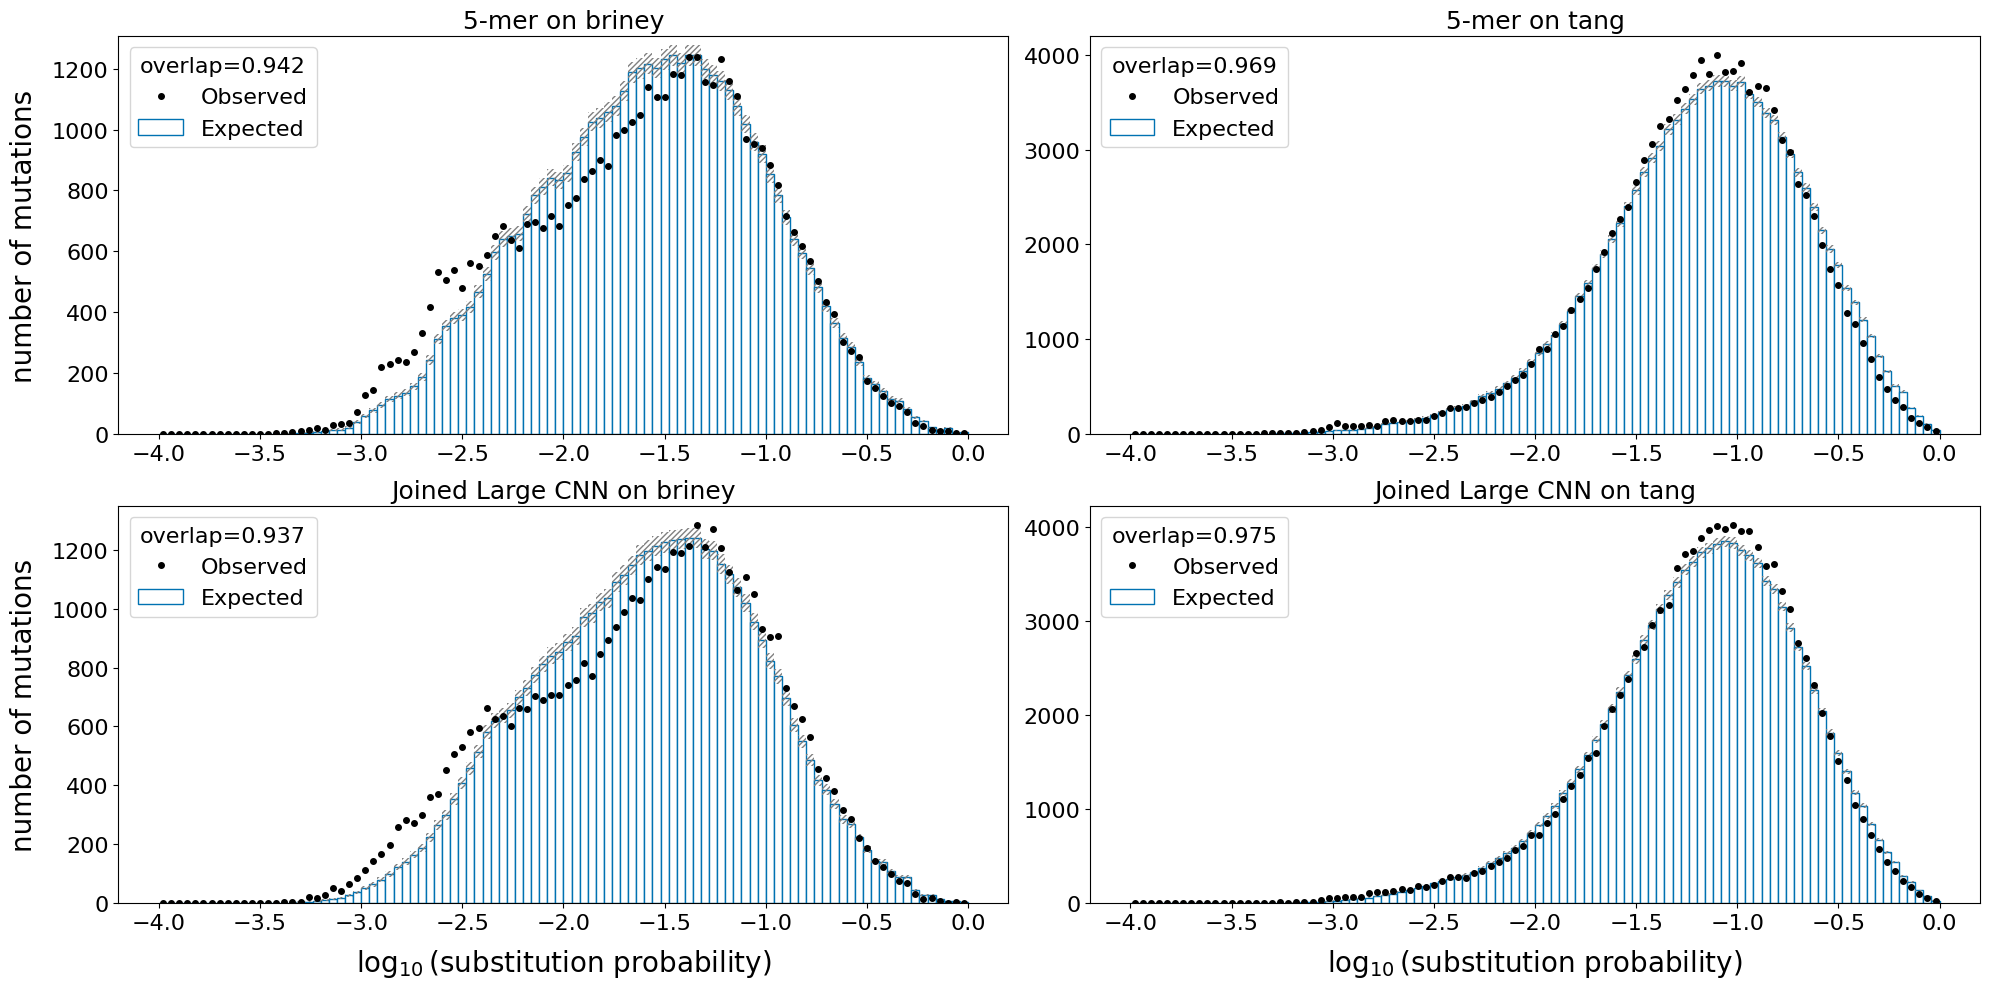

In [2]:
def make_oe_plot(
    crepe_prefix,
    dataset_name,
    min_log_prob,
    ax,
    restrict_evaluation_to_shmoof_region=False,
    optimize_branch_lengths=True,
):
    crepe_basename = os.path.basename(crepe_prefix)
    crepe = load_crepe(crepe_prefix)
    _, pcp_df = train_val_dfs_of_nicknames(dataset_name)
    if restrict_evaluation_to_shmoof_region:
        pcp_df["child"] = make_n_outside_of_shmoof_region(pcp_df["child"])
        pcp_df = pcp_df[pcp_df.apply(parent_and_child_differ, axis=1)]
    if optimize_branch_lengths:
        pcp_df = standardize_and_optimize_branch_lengths(crepe.model, pcp_df)

    if min_log_prob is not None:
        binning = np.linspace(min_log_prob, 0, 101)
    else:
        binning = None

    ratess, cspss = trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    site_count = crepe.encoder.site_count
    mut_indicators, base_idxss, masks = ragged_np_pcp_encoding(
        pcp_df["parent"], pcp_df["child"], site_count
    )
    val_bls = pcp_df["branch_length"].values
    fig, oe_results, _ = oe_plot_of(
        ratess,
        masks,
        val_bls,
        mut_indicators,
        binning=binning,
        ax=ax,
    )
    # ax.text(
    #     0.01,
    #     0.99,
    #     f"overlap={oe_results['overlap']:.3g}",
    #     transform=ax.transAxes,
    #     ha="left",
    #     va="top",
    #     fontsize=16,
    # )
    ax.legend(loc="upper left", title=f"overlap={oe_results['overlap']:.3g}", fontsize=16, title_fontsize=16)
    model_type = crepe_basename.split("-")[0]
    model_dict = {
        "fivemer": "5-mer",
        "cnn_joi_lrg": "Joined Large CNN",
    }
    data_dict = {
        "shmoof_notbig": "briney",
        "val_tangshm": "tang",
        "tst": "TEST",
    }
    ax.set_title(f"{model_dict[model_type]} on {data_dict[dataset_name]}", fontsize=18)
    oe_results


model_types = ["fivemer", "cnn_joi_lrg"]
datasets = ["shmoof_notbig", "val_tangshm"]
optimize_branch_lengths=True

# datasets = ["tst", "tst"]
# optimize_branch_lengths=False

fig, axes = plt.subplots(len(model_types), len(datasets), figsize=(10*len(model_types), 5*len(datasets)))

def local_oe_plot(model_type, dataset_name, ax):
    make_oe_plot(
        f"../train/trained_models/{model_type}-shmoof_notbig-simple-0",
        dataset_name,
        min_log_prob=-4,
        ax=ax,
        restrict_evaluation_to_shmoof_region=False,
        optimize_branch_lengths=optimize_branch_lengths,
    )

for i, model_type in enumerate(model_types):
    for j, dataset_name in enumerate(datasets):
        ax = axes[i, j]
        local_oe_plot(model_type, dataset_name, ax)
        if i != len(model_types) - 1:
            ax.set_xlabel("")
        if j != 0:
            ax.set_ylabel("")
        # make the legend in the upper left


plt.tight_layout()

fig.savefig("output/oe_plots.pdf")